In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install scikit-fmm
!pip install cairosvg
!pip install svgwrite

In [ ]:
!unzip /content/drive/MyDrive/problems.zip

Archive:  /content/drive/MyDrive/problems.zip
   creating: problems/
  inflating: problems/occlusion2.csv  
  inflating: problems/occlusion1.csv  
  inflating: problems/.DS_Store      
  inflating: __MACOSX/problems/._.DS_Store  
  inflating: problems/occlusion1_sol.svg  
  inflating: problems/frag01_sol.svg  
  inflating: problems/frag1.csv      
  inflating: problems/frag0.csv      
  inflating: problems/frag2.csv      
  inflating: problems/isolated.csv   
  inflating: problems/occlusion2_sol.svg  
  inflating: __MACOSX/problems/._occlusion2_sol.svg  
  inflating: problems/frag2_sol.csv  
  inflating: problems/isolated_sol.csv  
  inflating: problems/occlusion1_sol.csv  
  inflating: problems/occlusion1_sol_rec.png  
  inflating: problems/occlusion2_sol_rec.svg  
  inflating: problems/occlusion2_rec.svg  
  inflating: problems/frag01_sol.csv  
  inflating: problems/occlusion2.svg  
  inflating: problems/occlusion1_rec.png  
  inflating: problems/occlusion1.svg  
  inflating: __MACOS

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import svgwrite
import cairosvg
import os

In [ ]:
def convert_svg_to_jpg(svg_path, output_folder):
    filename = os.path.splitext(os.path.basename(svg_path))[0]
    output_path = os.path.join(output_folder, filename + '.jpg')

    cairosvg.svg2png(url=svg_path, write_to=output_path)
    print(f"Converted {svg_path} to {output_path}")

In [ ]:
svg_file = "/content/problems/occlusion1.svg"
output_dir = "/content/problems/"

convert_svg_to_jpg(svg_file, output_dir)

Converted /content/problems/occlusion1.svg to /content/problems/occlusion1.jpg


In [4]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [5]:
def extract_features(contours):
    shapes = []
    for contour in contours:
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        if len(approx) == 2:
            shape = "Line"
        elif len(approx) == 3:
            shape = "Triangle"
        elif len(approx) == 4:
            shape = "Rectangle" if 0.95 <= aspect_ratio <= 1.05 else "Quadrilateral"
            if shape == "Rectangle":
                is_rounded = False
                for i in range(len(approx)):
                    p1 = approx[i][0]
                    p2 = approx[(i + 1) % len(approx)][0]
                    corner_angle = np.degrees(np.arctan2(p2[1] - p1[1], p2[0] - p1[0]))
                    if 75 < corner_angle < 105 or -105 < corner_angle < -75:
                        is_rounded = True
                        break
                if is_rounded:
                    shape = "Rounded Rectangle"
        elif len(approx) > 10:
            (x, y), (MA, ma), angle = cv2.fitEllipse(approx)
            shape = "Circle" if 0.95 <= MA / ma <= 1.05 else "Ellipse"
        else:
            shape = "Polygon"
        shapes.append((shape, approx, area, perimeter))
    return shapes

In [6]:
def classify_shapes(shapes):
    classified_shapes = []
    for shape, approx, area, perimeter in shapes:
        if shape == "Line":
            classified_shapes.append(("Line", approx))
        elif shape == "Triangle":
            classified_shapes.append(("Triangle", approx))
        elif shape == "Rectangle":
            classified_shapes.append(("Rectangle", approx))
        elif shape == "Rounded Rectangle":
            classified_shapes.append(("Rounded Rectangle", approx))
        elif shape == "Circle":
            classified_shapes.append(("Circle", approx))
        elif shape == "Ellipse":
            classified_shapes.append(("Ellipse", approx))
        elif shape == "Polygon":
            if len(approx) == 5:
                classified_shapes.append(("Pentagon", approx))
            elif len(approx) == 6:
                classified_shapes.append(("Hexagon", approx))
            elif len(approx) == 7:
                classified_shapes.append(("Heptagon", approx))
            elif len(approx) == 8:
                classified_shapes.append(("Octagon", approx))
            else:
                classified_shapes.append(("Polygon", approx))
    return classified_shapes

In [7]:
def visualize_shapes(image_path, classified_shapes):
    image = cv2.imread(image_path)
    for shape, approx in classified_shapes:
        cv2.drawContours(image, [approx], 0, (0, 255, 0), 2)
        x, y = approx[0][0]
        cv2.putText(image, shape, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [8]:
def read_csv_(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

In [9]:
def is_high_curvature(p0, p1, p2, threshold=0.1):
    v1 = p1 - p0
    v2 = p2 - p1
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    return angle > threshold

In [10]:
def find_endpoints(curve, curvature_threshold=0.3):
    endpoints = []
    for i in range(1, len(curve) - 1):
        # Vectors representing the segments before and after the point
        v1 = curve[i] - curve[i - 1]
        v2 = curve[i + 1] - curve[i]

        # Normalize the vectors
        v1 = v1 / np.linalg.norm(v1)
        v2 = v2 / np.linalg.norm(v2)

        # Reshape vectors to be 1D for dot product
        v1 = v1.reshape(-1)
        v2 = v2.reshape(-1)

        # Calculate the angle between the vectors
        angle = np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))

        # If the angle is sharp (high curvature), consider it an endpoint
        if angle > curvature_threshold:
            endpoints.append(curve[i])

    # Include the first and last points as endpoints
    endpoints.append(curve[0])
    endpoints.append(curve[-1])

    return np.array(endpoints)

In [11]:
def estimate_control_points(P0, P3, tangent0, tangent3, distance=0.3):
    """
    Estimate the control points for a cubic Bezier curve given the
    start and end points and their tangents.

    Parameters:
    - P0: The starting point of the curve.
    - P3: The ending point of the curve.
    - tangent0: The tangent vector at the starting point P0.
    - tangent3: The tangent vector at the ending point P3.
    - distance: A factor controlling the distance of control points
    from the endpoints.

    Returns:
    - P1: The first control point.
    - P2: The second control point.
    """

    # Normalize the tangent vectors
    tangent0 = tangent0 / np.linalg.norm(tangent0)
    tangent3 = tangent3 / np.linalg.norm(tangent3)

    # Estimate control points
    P1 = P0 + distance * tangent0 * np.linalg.norm(P3 - P0)
    P2 = P3 - distance * tangent3 * np.linalg.norm(P3 - P0)

    return P1, P2

In [12]:
def bezier_curve(P0, P1, P2, P3, num_points=100):
    """
    Generate a cubic Bezier curve given four control points.

    Parameters:
    - P0: The starting point of the curve.
    - P1: The first control point.
    - P2: The second control point.
    - P3: The ending point of the curve.
    - num_points: Number of points to generate on the curve.

    Returns:
    - curve: A numpy array of points representing the Bezier curve.
    """
    t_values = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))

    for i, t in enumerate(t_values):
        curve[i] = (
            (1-t)**3 * P0 +
            3*(1-t)**2 * t * P1 +
            3*(1-t) * t**2 * P2 +
            t**3 * P3
        )

    return curve

In [13]:
def calculate_tangent(curve, point, epsilon=1e-3):
    idx = np.where(curve == point)[0][0]
    if idx == 0:
        return curve[1] - curve[0]
    elif idx == len(curve) - 1:
        return curve[-1] - curve[-2]
    else:
        return curve[idx + 1] - curve[idx - 1]

In [14]:
def complete_curve_with_bezier(P0, P3, curve):
    tangent0 = calculate_tangent(curve, P0)
    tangent3 = calculate_tangent(curve, P3)
    P1, P2 = estimate_control_points(P0, P3, tangent0, tangent3)
    bezier_points = bezier_curve(P0, P1, P2, P3)
    return bezier_points

In [15]:
def merge_curves(image, new_curve):
    for point in new_curve:
        cv2.circle(image, tuple(point.astype(int)), 1, (0, 255, 0), -1)
    return image

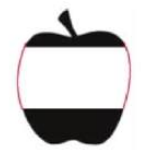

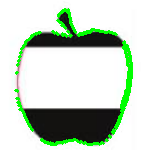

In [ ]:
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/trial.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_image, 100, 200)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

completed_image = image.copy()
for curve in contours:
    endpoints = find_endpoints(curve)
    for i in range(0, len(endpoints), 2):
        if i + 1 < len(endpoints):
            P0 = endpoints[i]
            P3 = endpoints[i + 1]
            new_curve = complete_curve_with_bezier(P0, P3, curve)
            completed_image = merge_curves(completed_image, new_curve)

cv2.imwrite('completed_image.png', completed_image)
cv2_imshow(image)
cv2_imshow(completed_image)

In [18]:
def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    # Create a new SVG drawing
    dwg = svgwrite.Drawing(svg_path, profile='tiny',
                           shape_rendering='crispEdges')
    group = dwg.g()

    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))
        group.add(dwg.path(d=path_data, fill=c,
                           stroke='none', stroke_width=2))

    dwg.add(group)
    dwg.save()

    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(url=svg_path, write_to=png_path,
                     parent_width=W, parent_height=H,
                     output_width=fact*W, output_height=fact*H,
                     background_color='white')

    return